# Chain (w/ langgraph)


In [8]:
from langchain_core.messages import AIMessage, HumanMessage
from pprint import pprint

messages = [
    HumanMessage(content='배고파', name='user1'),
    AIMessage(content='뭘 먹고 싶으세요?', name='LLM'),
    HumanMessage(content='몰라', name='user1'),
    # AIMessage(content='그러면 중국집은 어떠세요?', name='LLM'),
]

for m in messages:
    m.pretty_print()

================================ Human Message =================================
Name: user1

배고파
================================== Ai Message ==================================
Name: LLM

뭘 먹고 싶으세요?
================================ Human Message =================================
Name: user1

몰라


In [4]:
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4.1-nano')
result = llm.invoke(messages)

print(type(result))
result.pretty_print()

<class 'langchain_core.messages.ai.AIMessage'>
================================== Ai Message ==================================

그럴 때는 가볍게 간식을 먹거나 좋아하는 음료를 마시는 것도 좋을 것 같아요. 혹시 어떤 음식이 드시고 싶은지 생각나는 것이 있나요?


In [ ]:
# Tool Calling (커스텀 툴 -> Docstring""" 으로 설명을 잘 써야함)

def multiply(a: int, b: int) -> int:
    """Multiply a and b
    If there is no number, transform text to proper integer

    Args:
        a: first int
        b: second int
    """    
    return a * b


llm_with_tools = llm.bind_tools([multiply])

In [28]:
res = llm_with_tools.invoke([
    HumanMessage(content='일 곱하기 이가 뭐야?', name='user1')
])

In [29]:
res.tool_calls

[{'name': 'multiply',
  'args': {'a': 1, 'b': 2},
  'id': 'call_maP4K3DCTDR6Mal0VlGL8W7D',
  'type': 'tool_call'}]

## 메세지를 `State`로 사용하기

In [30]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

# 그래프 턴이 반복될 때, messages가 알아서 추가되도록 하려면?
class MessagesState(TypedDict):
    # messages 키에는 AnyMessage 의 인스턴스들이 리스트로 들어간다.
    messages: Annotated[list[AnyMessage], add_messages]


# 참고용
ms = [
    AIMessage(content='뭘 도와드릴까요'),
    HumanMessage(content='그냥 도와줘')
]

add_messages(ms, AIMessage(content='??????'))


[AIMessage(content='뭘 도와드릴까요', additional_kwargs={}, response_metadata={}, id='9e6597fc-a9fa-48ee-a81b-4a4ff899a1f8'),
 HumanMessage(content='그냥 도와줘', additional_kwargs={}, response_metadata={}, id='0a12d53a-3b07-4968-8dca-b2989e5e9885'),
 AIMessage(content='??????', additional_kwargs={}, response_metadata={}, id='e38841c8-26e2-4da0-9214-b77ad153b609')]

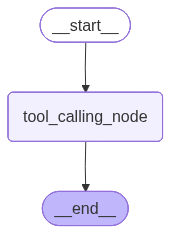

In [31]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Node
def tool_calling_node(state: MessagesState):
    msgs = state['messages']
    ans = llm_with_tools.invoke(msgs)
    return {'messages': ans}


builder = StateGraph(MessagesState)
builder.add_node('tool_calling_node', tool_calling_node)

builder.add_edge(START, 'tool_calling_node')
builder.add_edge('tool_calling_node', END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))